# Predicting avalanche problems based on meteorological data alone

We use the regional meteorological statisteics from APS to predict the most important avalanche problem for the given day and region.
The target variable is avalanche_problem_1_problem_type_id, which can have the following values:



| Value | Description|
|----|---|
| 0  | Ikke gitt|
| 3  | Loose dry avalanches|
| 5  | Loose wet avalanches|
| 7  | New snow slab|
| 10 |  Wind slab|
| 20 | New snow|
| 30 | Persistent slab|
| 37 | Persistent deep slab|
| 40 | Wet snow|
| 45 | Wet slab|
| 50 | Glide avalanche|

In order to get continous values we re-grouped it in the variable avalanche_problem_1_problem_type_id_class, which can have the following values:

| Value | Description|
|----|---|
| 0 | Not given |
| 1 | Loose dry |
| 2 | Loose wet |
| 3 | Glide avalanche |
| 4 | Wet slab |
| 5 | Storm slab |
| 6 | Wind slab |
| 7 | Persistent slab |

In [55]:
import pandas as pd
import numpy as np
import json
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split

sns.set(style="white")
pd.set_option("display.max_rows",6)

%matplotlib inline

In [56]:
df_data = pd.read_csv('varsom_ml_preproc.csv', index_col=0)

#[print(f'\'{c}\', ') for c in df_data.columns]

In [59]:
target_ = ['avalanche_problem_1_problem_type_id_class']
target_classes = {
    "0": "Not given",
    "1": "Loose dry",
    "2": "Loose wet",
    "3": "Glide avalanche",
    "4": "Wet slab",
    "5": "Storm slab",
    "6": "Wind slab",
    "7": "Persistent slab"
    }
features_ = [
    #'mountain_weather_freezing_level', # correlates with min/max temperature
    'mountain_weather_precip_most_exposed', 
    'mountain_weather_precip_region', 
    'mountain_weather_temperature_elevation', 
    'mountain_weather_temperature_max', 
    'mountain_weather_temperature_min', 
    'mountain_weather_wind_speed_num', 
    #'mountain_weather_wind_direction_num', 
    'mountain_weather_wind_direction_E', 
    'mountain_weather_wind_direction_N', 
    'mountain_weather_wind_direction_NE', 
    'mountain_weather_wind_direction_NW', 
    'mountain_weather_wind_direction_None', 
    'mountain_weather_wind_direction_S', 
    'mountain_weather_wind_direction_SE', 
    'mountain_weather_wind_direction_SW', 
    'mountain_weather_wind_direction_W',
    #'region_id',  # correlates with region_group_id
    'region_group_id'
    #'region_type_id'  # currently only A in the dataset
    ]
X = df_data.filter(features_, axis=1)
y = df_data.filter(target_, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 222, test_size = 0.3)

Check which variables are strongly correlated and could be reduced.

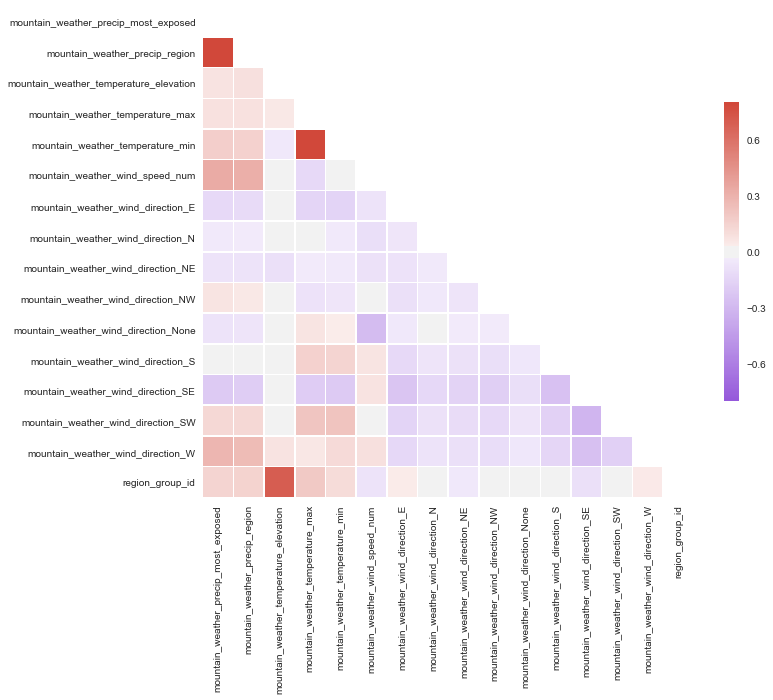

In [60]:
# Compute the correlation matrix - works only on numerical variables.
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

(1147,) (1147, 1)
Decision tree R^2: 0.5981


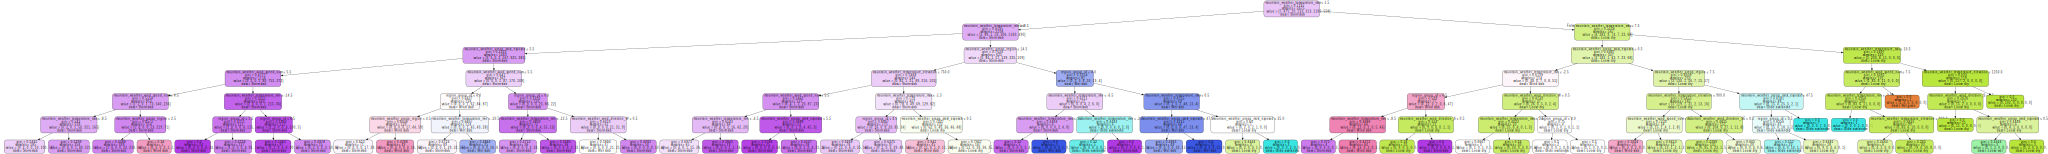

In [69]:
dec_tree = tree.DecisionTreeClassifier(random_state=222, max_depth = 6)

dec_tree.fit(X_train, y_train) # we're using the same data as in last linear model

predictions_dt = dec_tree.predict(X_test)
print(predictions_dt.shape, y_test.shape)

print('Decision tree R^2: %.4f' % dec_tree.score(X_test, y_test)) 


# Visualize the tree
dot_data = tree.export_graphviz(dec_tree, out_file=None,  #'tree.dot', 
                         feature_names=features_,
                         class_names=list(target_classes.values()),
                         filled=True, rounded=True, #rotate=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

Text(0,0.5,'$R^2$')

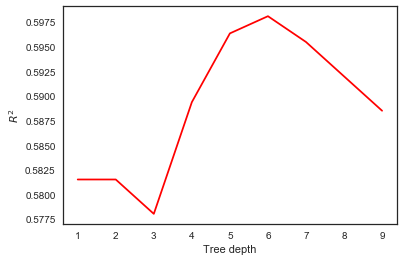

In [70]:
depths = range(1, 10)

tree_models = [tree.DecisionTreeClassifier(random_state=222, max_depth=d).fit(X_train, y_train) for d in depths]
tree_Rsquare = [f.score(X_test, y_test) for f in tree_models]

plt.plot(depths, tree_Rsquare, color = 'red')
plt.xlabel('Tree depth')
plt.ylabel('$R^2$')

In [71]:
grad_boost = GradientBoostingClassifier(random_state = 12, max_depth = 6)

grad_boost.fit(X_train, y_train)

predictions_gb = grad_boost.predict(X_test)

print('Gradient boosted tree R^2: %.4f' % grad_boost.score(X_test, y_test)) 

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient boosted tree R^2: 0.6478


In [72]:
importance = grad_boost.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print(f'{features_[index]}: \t{(importance[index] *100.0):.2f}%')

mountain_weather_wind_direction_None: 	0.29%
mountain_weather_wind_direction_N: 	0.68%
mountain_weather_wind_direction_NW: 	0.95%
mountain_weather_wind_direction_NE: 	1.05%
mountain_weather_wind_direction_E: 	1.10%
mountain_weather_wind_direction_W: 	1.64%
mountain_weather_wind_direction_SW: 	1.80%
mountain_weather_wind_direction_S: 	2.03%
mountain_weather_wind_direction_SE: 	2.49%
mountain_weather_temperature_elevation: 	5.09%
mountain_weather_precip_region: 	7.23%
mountain_weather_wind_speed_num: 	9.49%
region_group_id: 	12.91%
mountain_weather_precip_most_exposed: 	13.70%
mountain_weather_temperature_max: 	17.35%
mountain_weather_temperature_min: 	20.93%
